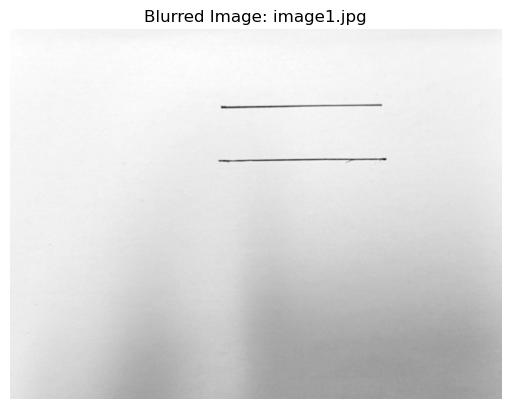

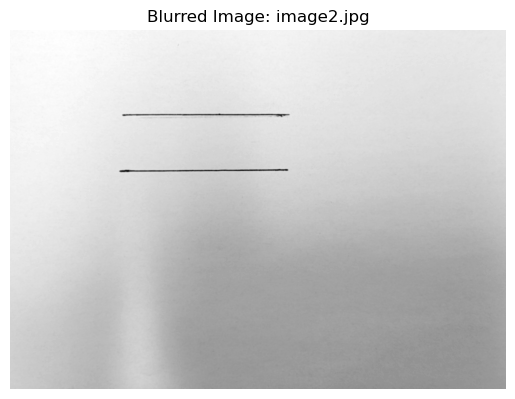

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def preprocess_image(image_path):
    """ Reads and blurs the image to reduce noise. """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return None
    img_blur = cv2.GaussianBlur(img, (7, 7), 0)  # Slightly increased blur to smooth edges
    img_filtered = cv2.medianBlur(img_blur, 5)
    return img_filtered

# List of image paths
image_paths = ["image1.jpg", "image2.jpg"]  # Replace with your image paths

# Preprocess all images and show their blurred versions
blurred_images = []
for image_path in image_paths:
    img_blur = preprocess_image(image_path)
    if img_blur is not None:
        blurred_images.append((image_path, img_blur))
        plt.imshow(img_blur, cmap='gray')
        plt.title(f"Blurred Image: {image_path}")
        plt.axis("off")
        plt.show()


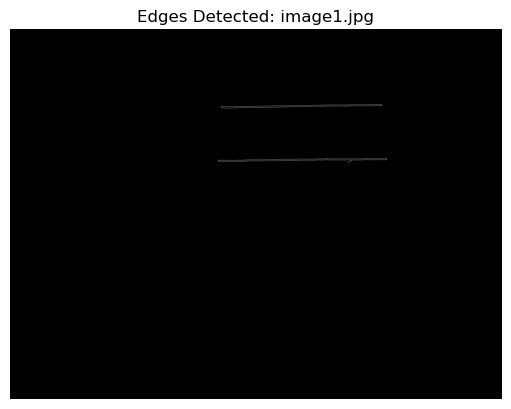

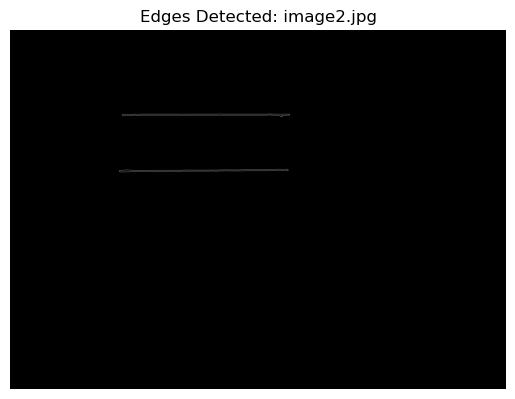

In [3]:
def detect_edges(image):
    """ Detects edges using Canny edge detection. """
    edges = cv2.Canny(image, 100, 200, apertureSize=3)
    return edges

# Detect edges for all preprocessed images
edges_images = []
for image_path, img_blur in blurred_images:
    edges = detect_edges(img_blur)
    edges_images.append((image_path, edges))
    plt.imshow(edges, cmap='gray')
    plt.title(f"Edges Detected: {image_path}")
    plt.axis("off")
    plt.show()


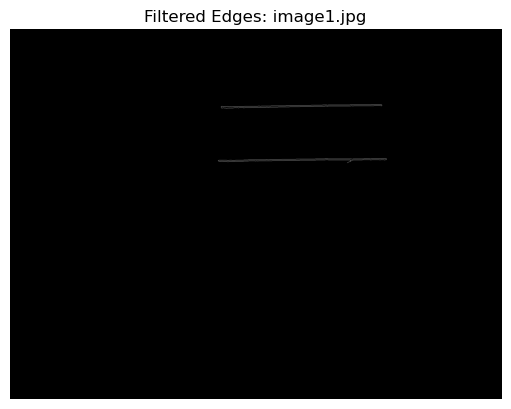

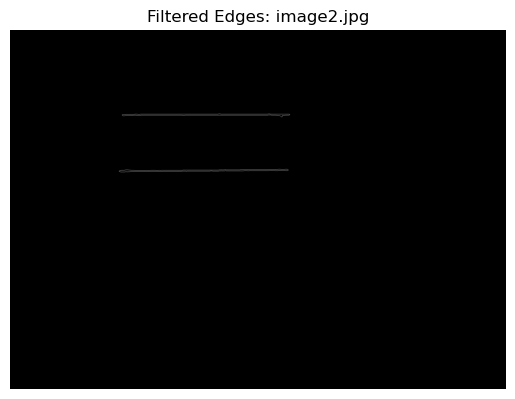

In [4]:
def filter_short_edges(edges, min_length=80):
   # """ Filters out very short edges detected by Canny edge detection. """
    #contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #filtered_edges = np.zeros_like(edges)
    
   # for contour in contours:
    #    if cv2.arcLength(contour, False) > min_line_length:  # Length threshold
 #           cv2.drawContours(filtered_edges, [contour], -1, 255, 1)
    
  #  return filtered_edges

    # Step 1: Apply Morphological Closing to remove small gaps and smooth edges
    kernel = np.ones((3, 3), np.uint8)
    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Step 2: Find contours
    contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Step 3: Create a blank image to draw only valid long contours
    filtered_edges = np.zeros_like(edges)

    for contour in contours:
        length = cv2.arcLength(contour, closed=False)
        
        # Step 4: Remove very short edges and microdeviations
        if length > min_length:  
            cv2.drawContours(filtered_edges, [contour], -1, 255, thickness=1)

    return filtered_edges

# Filter edges for all preprocessed images
filtered_edges_images = []
for image_path, edges in edges_images:
    filtered_edges = filter_short_edges(edges)
    filtered_edges_images.append((image_path, filtered_edges))
    
    plt.imshow(filtered_edges, cmap='gray')
    plt.title(f"Filtered Edges: {image_path}")
    plt.axis("off")
    plt.show()


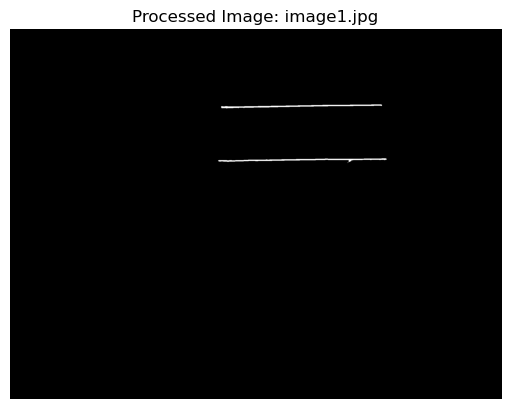

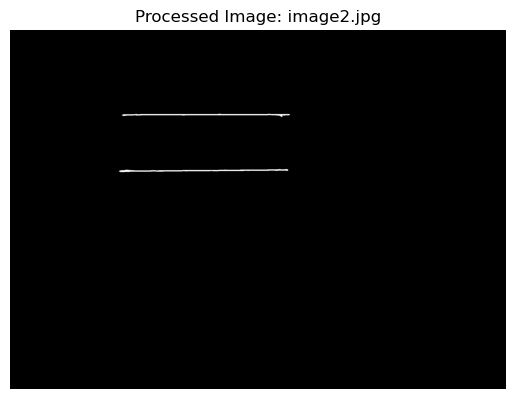

In [5]:
def post_process(image):
    """ Enhances detected lines by morphological closing and careful dilation. """
    kernel = np.ones((5, 5), np.uint8)  # Larger kernel for closing operation
    closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)
    dilated = cv2.dilate(closed, kernel, iterations=1)
    thinned = cv2.erode(dilated, kernel, iterations=1)
    return thinned

# Post-process edges for all images
processed_images = []
for image_path, filtered_edges in filtered_edges_images:
    final_output = post_process(filtered_edges)
    processed_images.append((image_path, final_output))
    plt.imshow(final_output, cmap='gray')
    plt.title(f"Processed Image: {image_path}")
    plt.axis("off")
    plt.show()


In [6]:
def save_processed_image(image, original_image_path):
    """ Saves the processed image to a file. """
    if image is not None:
        output_filename = os.path.splitext(original_image_path)[0] + "_processed.jpg"
        cv2.imwrite(output_filename, image)
        print(f"Processed image saved as: {output_filename}")

# Save the processed images
for image_path, processed_image in processed_images:
    save_processed_image(processed_image, image_path)


Processed image saved as: image1_processed.jpg
Processed image saved as: image2_processed.jpg


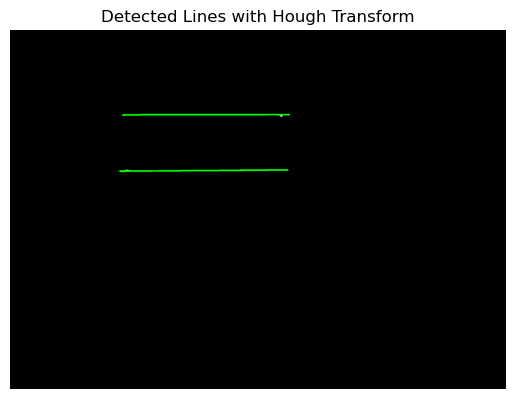

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Apply Hough Line Transform
def detect_lines(image):
    """ Detects lines using Hough Line Transform. """
    lines = cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)
    return lines

# Detect lines in the processed image
lines = detect_lines(final_output)

# Visualize detected lines
output_image = cv2.cvtColor(final_output, cv2.COLOR_GRAY2BGR)  # Convert to color for line overlay

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]  # Extract line endpoints
        cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw line in green

plt.imshow(output_image)
plt.title("Detected Lines with Hough Transform")
plt.axis("off")
plt.show()


In [ ]:
# Store detected line coordinates for all images
detected_lines = []

for image_path, processed_image in processed_images:  # Loop through all processed images
    lines = detect_lines(processed_image)
    output_image = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2BGR)  # Convert to color for overlay

    image_lines = []  # Store lines for this image
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]  # Extract start and end points
            image_lines.append(((x1, y1), (x2, y2)))  # Store coordinates
            cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw the line

    detected_lines.append((image_path, image_lines))  # Store detected lines for this image
    
    # Display the image with detected lines
    plt.imshow(output_image)
    plt.title(f"Detected Lines: {image_path}")
    plt.axis("off")
    plt.show()

# Print the start and end points of each detected line
for image_path, lines in detected_lines:
    print(f"Lines detected in {image_path}:")
    for (start, end) in lines:
        print(f"Start: {start}, End: {end}")

In [ ]:
def merge_similar_lines(lines, threshold=10):
    merged_lines = []
    
    # Print the lines structure for debugging
    print("Lines:", lines)

    for line in lines:
        print("Processing line:", line)  # Debugging output
        
        # If line is a numpy array, convert it to a tuple for unpacking
        if isinstance(line, np.ndarray):
            line = tuple(map(tuple, line))  # Convert to tuple if needed

        # Make sure that line has two pairs (x1, y1) and (x2, y2)
        if len(line) == 2 and len(line[0]) == 2 and len(line[1]) == 2:
            (x1, y1), (x2, y2) = line  # Unpack
        else:
            print(f"Skipping invalid line format: {line}")
            continue  # Skip if the line is not in expected format

        added = False
        for mline in merged_lines:
            (mx1, my1), (mx2, my2) = mline

            # Check if the lines are close enough to be merged
            if abs(y1 - my1) < threshold and abs(y2 - my2) < threshold:
                added = True
                break

        if not added:
            merged_lines.append(line)

    return merged_lines

# Apply filtering to detected lines
filtered_detected_lines = []

for image_path, image_lines in detected_lines:
    merged_lines = merge_similar_lines(lines)
    filtered_detected_lines.append((image_path, merged_lines))

    # Print the cleaned line detections
    print(f"Filtered Lines in {image_path}:")
    for merged_line in merged_lines:
        (x1, y1), (x2, y2) = merged_line  # Unpack the line correctly
        print(f"Start: ({x1}, {y1}), End: ({x2}, {y2})")


In [ ]:
import math

def merge_similar_lines(lines, distance_threshold=50, angle_threshold=15):
    merged_lines = []
    
    def line_distance(line1, line2):
        # Calculate the Euclidean distance between the start and end points of the lines
        (x1, y1), (x2, y2) = line1
        (x3, y3), (x4, y4) = line2
        return math.sqrt((x1 - x3) ** 2 + (y1 - y3) ** 2 + (x2 - x4) ** 2 + (y2 - y4) ** 2)
    
    for line in lines:
        added = False
        for mline in merged_lines:
            # Compare the current line with already merged lines
            if line_distance(line, mline) < distance_threshold:
                # If the lines are close, merge them by averaging the coordinates
                (x1, y1), (x2, y2) = line
                (mx1, my1), (mx2, my2) = mline
                merged_lines.remove(mline)
                new_line = ((min(x1, mx1), min(y1, my1)), (max(x2, mx2), max(y2, my2)))
                merged_lines.append(new_line)
                added = True
                break
        if not added:
            merged_lines.append(line)

    return merged_lines


# Apply filtering to detected lines
filtered_detected_lines = []

for image_path, image_lines in detected_lines:
    print(f"Processing {image_path} with {len(image_lines)} lines")
    for line in image_lines:
        print(f"Line: {line}")
    merged_lines = merge_similar_lines(image_lines, distance_threshold=10)  # Adjust threshold as needed
    filtered_detected_lines.append((image_path, merged_lines))

    # Print the cleaned line detections
    print(f"Filtered Lines in {image_path}:")
    for merged_line in merged_lines:
        (x1, y1), (x2, y2) = merged_line  # Unpack the line correctly
        print(f"Start: ({x1}, {y1}), End: ({x2}, {y2})")

In [64]:
import numpy as np

def euclidean_distance(line1, line2):
    (x1, y1), (x2, y2) = line1
    (x3, y3), (x4, y4) = line2
    dist1 = np.sqrt((x1 - x3) ** 2 + (y1 - y3) ** 2)
    dist2 = np.sqrt((x2 - x4) ** 2 + (y2 - y4) ** 2)
    return min(dist1, dist2)

def merge_similar_lines_v2(lines, threshold=30):
    merged_lines = []
    lines.sort(key=lambda line: line[0][1])  # Sort by y1 coordinate

    for line in lines:
        (x1, y1), (x2, y2) = line
        added = False

        for mline in merged_lines:
            (mx1, my1), (mx2, my2) = mline
            # Calculate Euclidean distance between endpoints
            if euclidean_distance(line, mline) < threshold:
                # Merge lines by adjusting the endpoints
                merged_lines.remove(mline)
                merged_lines.append(((min(x1, mx1), min(y1, my1)), (max(x2, mx2), max(y2, my2))))
                added = True
                break

        if not added:
            merged_lines.append(((x1, y1), (x2, y2)))

    return merged_lines

# Apply filtering to detected lines
filtered_detected_lines = []

for image_path, image_lines in detected_lines:
    merged_lines = merge_similar_lines_v2(lines)
    filtered_detected_lines.append((image_path, merged_lines))

    # Print the cleaned line detections
    print(f"Filtered Lines in {image_path}:")
    for merged_line in merged_lines:
        (x1, y1), (x2, y2) = merged_line
        print(f"Start: ({x1}, {y1}), End: ({x2}, {y2})")

Filtered Lines in image1.jpg:
Start: (943, 344), End: (1661, 341)
Start: (943, 346), End: (1661, 353)
Start: (1044, 585), End: (1261, 582)
Start: (1157, 586), End: (1367, 582)
Start: (936, 581), End: (1682, 582)
Start: (930, 586), End: (1635, 592)
Filtered Lines in image2.jpg:
Start: (943, 344), End: (1661, 341)
Start: (943, 346), End: (1661, 353)
Start: (1044, 585), End: (1261, 582)
Start: (1157, 586), End: (1367, 582)
Start: (936, 581), End: (1682, 582)
Start: (930, 586), End: (1635, 592)


In [ ]:
def visualize_lines(image_path, lines):
    # Read the image
    image = cv2.imread(image_path)
    image_copy = image.copy()

    # Iterate through the lines and draw them on the image
    for line in lines:
        # Unpack the line points
        (x1, y1), (x2, y2) = line

        # Draw the line on the image (color: green, thickness: 2)
        cv2.line(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Show the image with lines drawn
    cv2.imshow(f"Lines in {image_path}", image_copy)
    cv2.waitKey(0)  # Wait for a key press to close the window
    cv2.destroyAllWindows()

# Visualize detected lines for each image
for image_path, lines in filtered_detected_lines:
    visualize_lines(image_path, lines)

Coordinates for image1.jpg:
Start: (1660, 578), End: (1659, 579)
Start: (1659, 579), End: (1581, 579)
Start: (1581, 579), End: (1580, 580)
Start: (1580, 580), End: (1420, 580)
Start: (1420, 580), End: (1419, 579)
Start: (1419, 579), End: (1407, 579)
Start: (1407, 579), End: (1406, 580)
Start: (1406, 580), End: (1364, 580)
Start: (1364, 580), End: (1363, 581)
Start: (1363, 581), End: (1278, 581)
Start: (1278, 581), End: (1277, 582)
Start: (1277, 582), End: (1213, 582)
Start: (1213, 582), End: (1212, 583)
Start: (1212, 583), End: (1159, 583)
Start: (1159, 583), End: (1158, 584)
Start: (1158, 584), End: (1150, 584)
Start: (1150, 584), End: (1149, 583)
Start: (1149, 583), End: (1143, 583)
Start: (1143, 583), End: (1142, 584)
Start: (1142, 584), End: (1064, 584)
Start: (1064, 584), End: (1063, 585)
Start: (1063, 585), End: (1044, 585)
Start: (1044, 585), End: (1043, 586)
Start: (1043, 586), End: (1007, 586)
Start: (1007, 586), End: (1006, 587)
Start: (1006, 587), End: (991, 587)
Start: (991

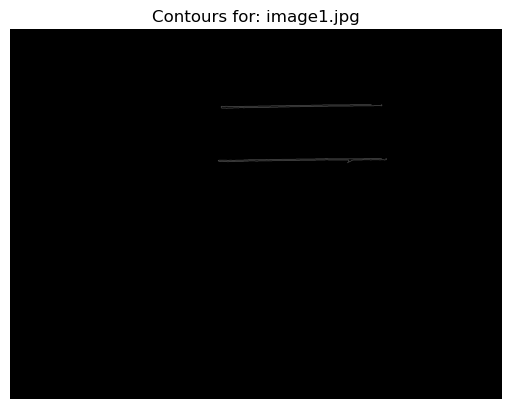

Coordinates for image2.jpg:
Start: (1242, 644), End: (1241, 645)
Start: (1241, 645), End: (1195, 645)
Start: (1195, 645), End: (1194, 646)
Start: (1194, 646), End: (1067, 646)
Start: (1067, 646), End: (1066, 647)
Start: (1066, 647), End: (1000, 647)
Start: (1000, 647), End: (999, 646)
Start: (999, 646), End: (994, 646)
Start: (994, 646), End: (993, 647)
Start: (993, 647), End: (968, 647)
Start: (968, 647), End: (967, 648)
Start: (967, 648), End: (800, 648)
Start: (800, 648), End: (799, 649)
Start: (799, 649), End: (689, 649)
Start: (689, 649), End: (688, 650)
Start: (688, 650), End: (675, 650)
Start: (675, 650), End: (674, 649)
Start: (674, 649), End: (652, 649)
Start: (652, 649), End: (651, 650)
Start: (651, 650), End: (576, 650)
Start: (576, 650), End: (575, 649)
Start: (575, 649), End: (559, 649)
Start: (559, 649), End: (558, 648)
Start: (558, 648), End: (549, 648)
Start: (549, 648), End: (548, 647)
Start: (548, 647), End: (535, 647)
Start: (535, 647), End: (534, 648)
Start: (534, 6

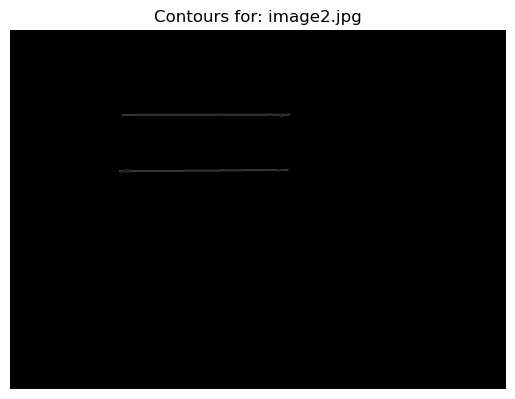

In [14]:
def extract_contours_from_edges(edges):
    """ Extract contours from the edge-detected image and get the start/end coordinates. """
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    lines = []  # To store the lines' coordinates
    
    # Iterate through all contours
    for contour in contours:
        if len(contour) > 1:  # Ensure the contour has more than 1 point
            # Approximate the contour as a line if necessary, otherwise use the contour itself
            for i in range(len(contour) - 1):
                start_point = tuple(contour[i][0])  # Get the x, y coordinates as tuple
                end_point = tuple(contour[i + 1][0])
                
                # Store the start and end coordinates of the line
                lines.append((start_point, end_point))
    
    return lines

# After processing the edges, extract the contours and coordinates
contour_coordinates = []
for image_path, final_output in processed_images:
    contours = extract_contours_from_edges(final_output)
    
    # Collect the coordinates of the lines
    image_lines = []
    for start_point, end_point in contours:
        image_lines.append({
            "Start": start_point, 
            "End": end_point
        })
    
    contour_coordinates.append((image_path, image_lines))

    # Print the coordinates for each image
    print(f"Coordinates for {image_path}:")
    for line in image_lines:
        print(f"Start: {line['Start']}, End: {line['End']}")

    # You can also visualize the contours if needed
    contour_image = np.zeros_like(final_output)
    for start_point, end_point in contours:
        cv2.line(contour_image, start_point, end_point, 255, 1)
    
    # Show the contour image
    plt.imshow(contour_image, cmap='gray')
    plt.title(f"Contours for: {image_path}")
    plt.axis("off")
    plt.show()


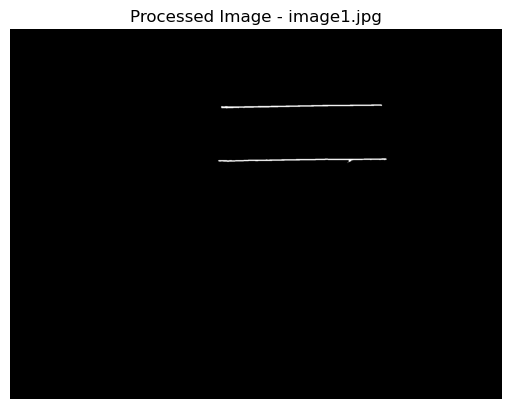

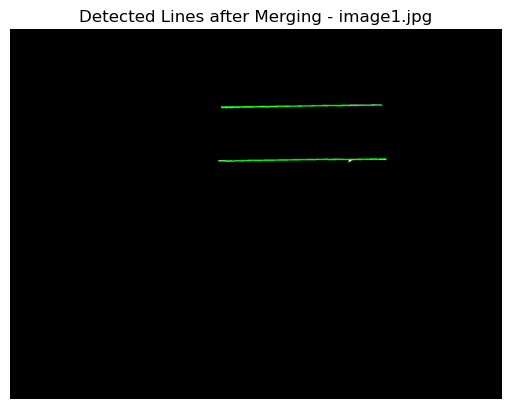

Detected 9 lines in image1.jpg:
Start: (1092, 589), End: (1680, 579)
Start: (932, 591), End: (1639, 579)
Start: (945, 352), End: (1661, 339)
Start: (943, 348), End: (1510, 339)
Start: (930, 589), End: (1473, 580)
Start: (1038, 586), End: (1357, 581)
Start: (1453, 344), End: (1661, 341)
Start: (943, 347), End: (1224, 343)
Start: (1421, 585), End: (1682, 581)


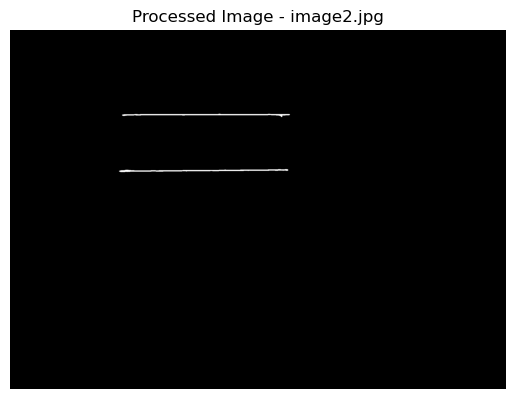

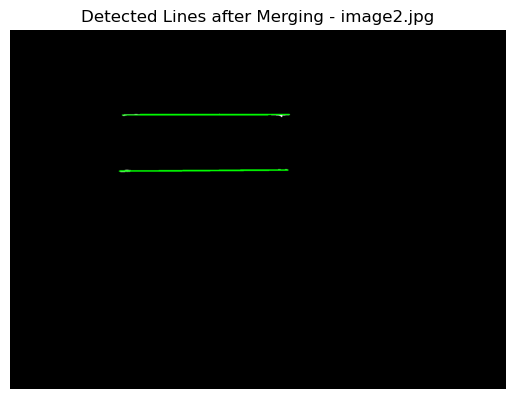

Detected 12 lines in image2.jpg:
Start: (519, 392), End: (1296, 392)
Start: (519, 394), End: (1195, 394)
Start: (509, 650), End: (1287, 650)
Start: (508, 651), End: (1200, 651)
Start: (603, 389), End: (1294, 389)
Start: (689, 649), End: (1289, 649)
Start: (505, 652), End: (1082, 652)
Start: (800, 648), End: (1288, 648)
Start: (505, 653), End: (927, 653)
Start: (968, 647), End: (1288, 647)
Start: (505, 654), End: (796, 654)
Start: (1067, 646), End: (1288, 646)


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_lines_using_hough(edges, min_line_length=200, max_line_gap=5, threshold=200):
    """ Detects lines using Hough Line Transform with stricter parameters. """
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)
    return lines

def merge_close_lines(lines, distance_threshold=50):
    """ Merge lines that are very close to each other (same physical line). """
    if lines is None:
        return []
    
    merged_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        merged = False
        for merged_line in merged_lines:
            mx1, my1, mx2, my2 = merged_line
            # Check if the start and end points are close enough to merge
            if np.abs(x1 - mx1) < distance_threshold and np.abs(y1 - my1) < distance_threshold and \
               np.abs(x2 - mx2) < distance_threshold and np.abs(y2 - my2) < distance_threshold:
                # Merge lines by averaging or extending them
                merged_line = [min(x1, mx1), min(y1, my1), max(x2, mx2), max(y2, my2)]
                merged = True
                break
        
        if not merged:
            merged_lines.append([x1, y1, x2, y2])
    
    return merged_lines

# Assuming 'processed_images' contains the final_output of both images after all processing steps
for image_path, final_output in processed_images:
    # Step 1: Visualize the processed image to check edge behavior
    plt.imshow(final_output, cmap='gray')
    plt.title(f"Processed Image - {image_path}")
    plt.axis("off")
    plt.show()
    
    # Step 2: Detect lines using Hough Line Transform with stricter parameters
    lines = detect_lines_using_hough(final_output, min_line_length=200, max_line_gap=5, threshold=200)
    
    # Step 3: Merge close lines
    lines = merge_close_lines(lines, distance_threshold=50)

    # Visualizing the result with detected lines
    visualized_img = cv2.cvtColor(final_output, cv2.COLOR_GRAY2BGR)  # Convert to color for visualization
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            cv2.line(visualized_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw line in green

    # Show the image with the detected lines
    plt.imshow(cv2.cvtColor(visualized_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Lines after Merging - {image_path}")
    plt.axis("off")
    plt.show()

    # Output the coordinates of the lines
    if lines is not None:
        print(f"Detected {len(lines)} lines in {image_path}:")
        for line in lines:
            x1, y1, x2, y2 = line
            print(f"Start: ({x1}, {y1}), End: ({x2}, {y2})")
